In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

import eddydiff as ed
import xarray as xr

In [41]:
plt.rcParams["figure.dpi"] = 140
plt.rcParams["figure.facecolor"] = "none"  # "F5F5EE"
plt.rcParams["axes.facecolor"] = (0.99,) * 3
plt.rcParams["grid.color"] = (0.25,) * 3
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["font.sans-serif"] = "Fira Sans"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.edgecolor"] = "darkgray"

In [79]:
argo_fine_depth["pressure"] = ("pressure_bins", np.arange(350, 1950, 200))
argo_fine_depth = argo_fine_depth.swap_dims({"pressure_bins": "pressure"})
argo_fine_depth["pressure_bins"] = ed.intervals_to_bounds(
    argo_fine_depth.pressure_bins
).rename({"gamma_n": "pressure"})

argo_fine_depth["pressure"].attrs["bounds"] = "pressure_bins"

In [207]:
a05_finescale = (
    xr.open_dataset(ed.sections.get_filenames("A05_2015")["finescale"])
    .sel(station=a05_binned.station.data)
    .mean("station")
)
a05_finescale = a05_finescale.cf.add_bounds("Z")
a05_finescale

<xarray.Dataset>
Dimensions:             (pressure: 65, criteria: 4, bounds: 2)
Coordinates:
  * pressure            (pressure) float64 200.0 300.0 ... 6.499e+03 6.549e+03
  * criteria            (criteria) object 'mixsea' 'kunze' 'whalen' 'whalen_7'
    profile_type        object ...
    geometry_container  float64 ...
    expocode            object ...
    cast                int8 ...
    section_id          object ...
    pressure_bounds     (bounds, pressure) float64 150.0 250.0 ... 6.574e+03
Dimensions without coordinates: bounds
Data variables: (12/14)
    ε                   (pressure, criteria) float64 3.416e-10 4.708e-08 ... nan
    Kρ                  (pressure, criteria) float64 2.595e-06 0.000324 ... nan
    ξvar                (pressure, criteria) float64 0.2131 0.06505 ... nan nan
    ξvargm              (pressure, criteria) float64 0.2975 0.04085 ... 0.1788
    Tzlin               (pressure) float64 0.01906 0.01918 0.01637 ... nan nan
    Tzmean              (pressure) float64 0.02098 0.01917 0.01643 ... 0.0 0.0
    ...                  ...
    Tmode               float64 80.3
    σmode               float64 77.87
    Tmld                float64 72.65
    σmld                float64 48.22
    χ                   (pressure, criteria) float64 2.219e-09 3.122e-07 ... nan
    KtTz                (pressure, criteria) float64 5.29e-08 7.001e-06 ... nan

## 2022-06 GRC 

### ∇S

In [26]:
cole = ed.read_cole()
cole.salinity_gradient.attrs["long_name"] = "$|∇_ρS|$"

Text(0.5, 1.0, '')

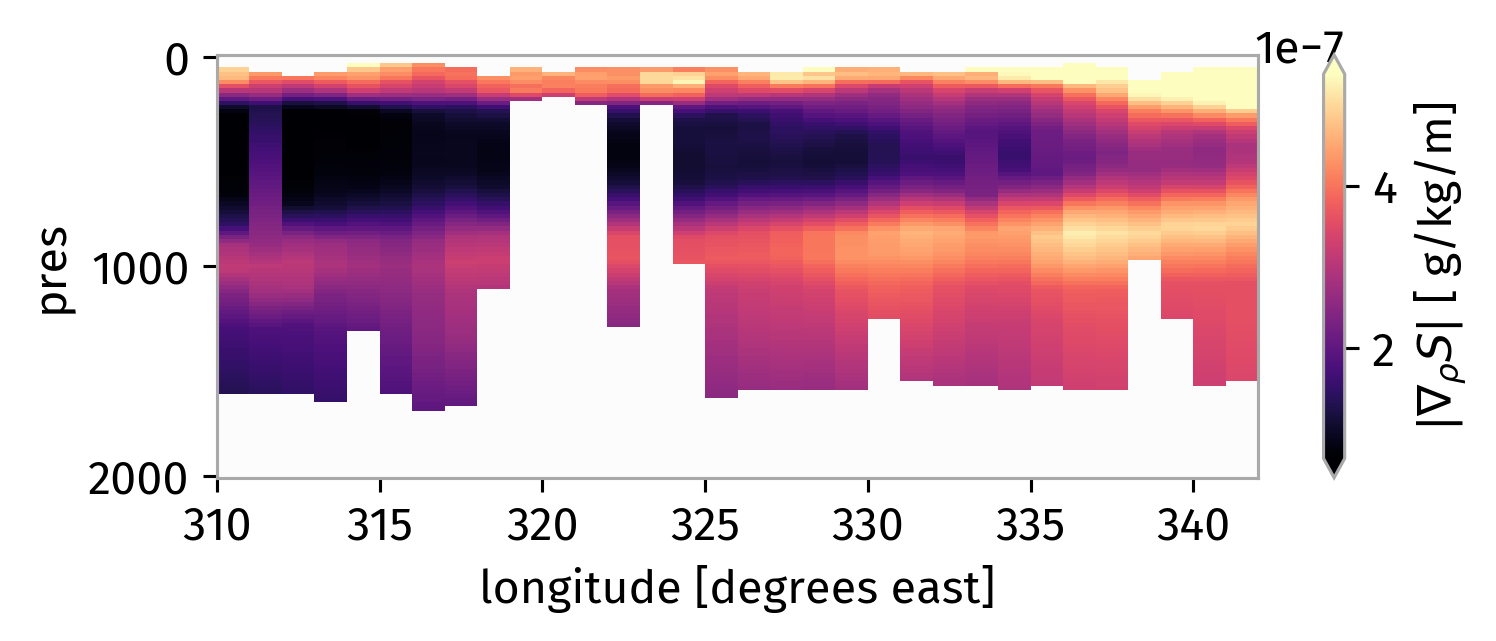

In [52]:
import matplotlib as mpl

(
    cole.salinity_gradient.sel(lon=slice(360 - 50, 342))
    .sel(lat=24.7, method="nearest")
    .cf.plot(robust=True, cmap=mpl.cm.magma, size=2, aspect=3)
)
plt.title("")

### Variance budget

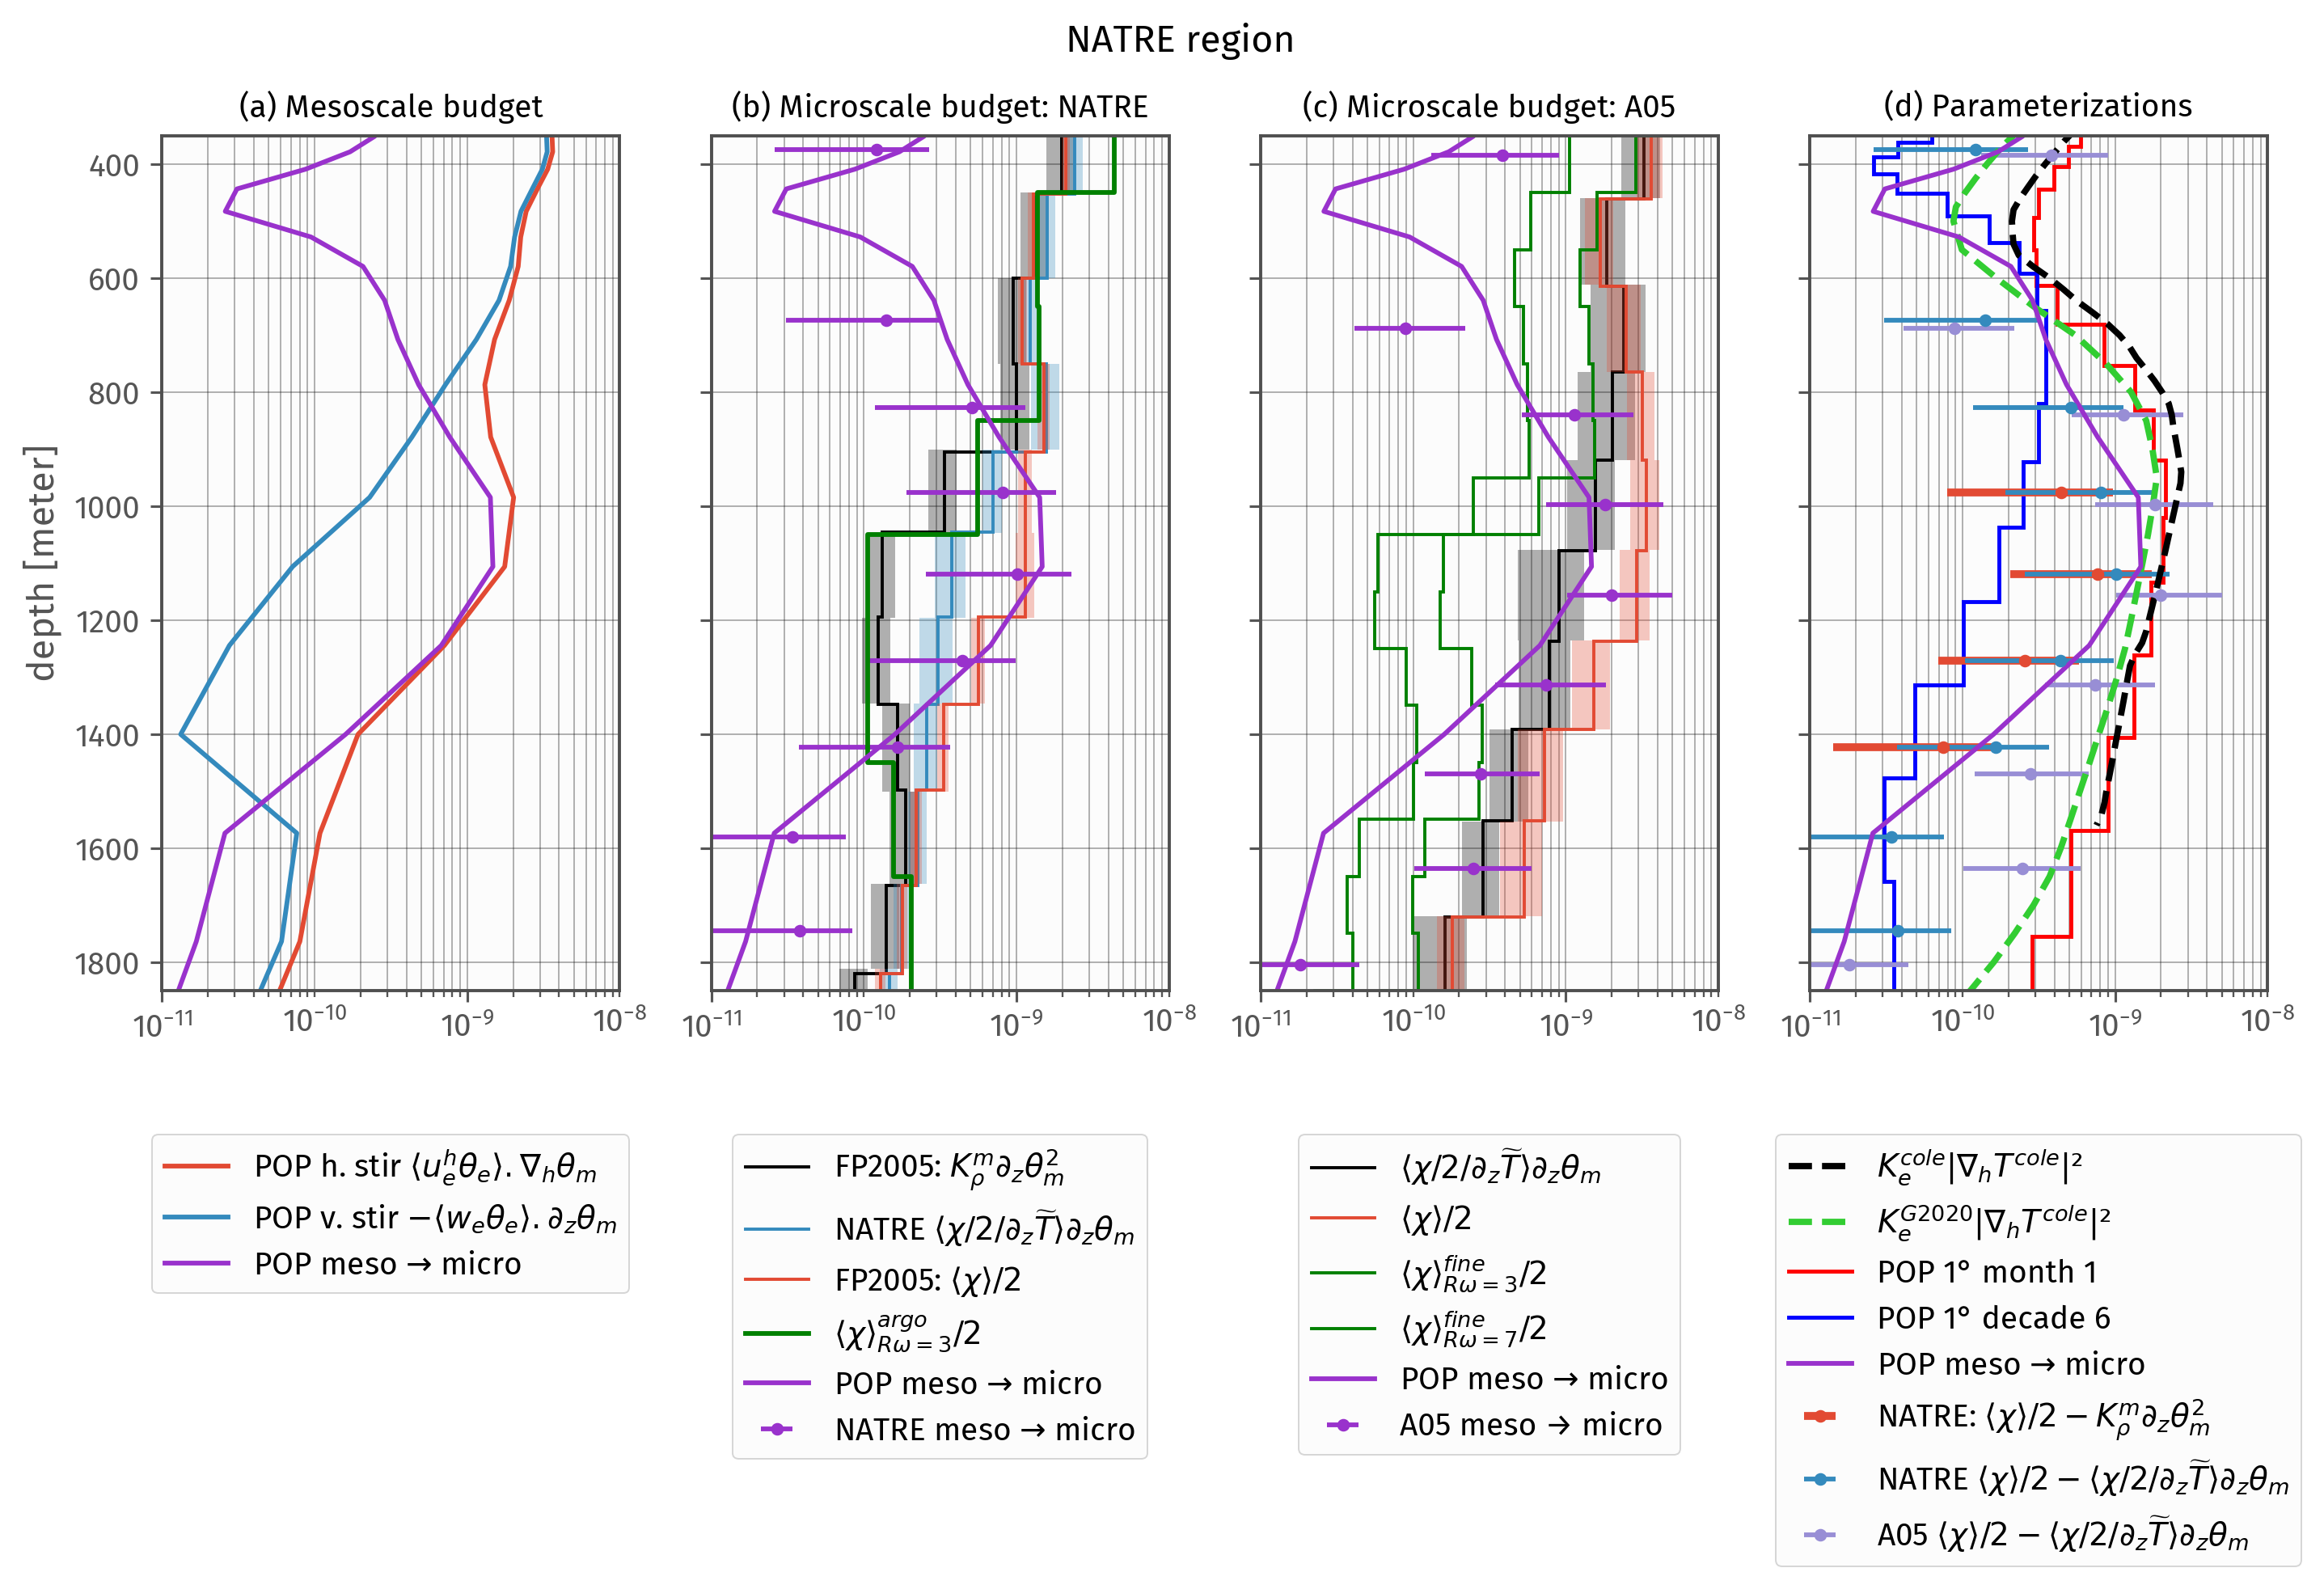

In [223]:
micro.pres.attrs["bounds"] = "pres_err"


def get_edges(pop):
    ybounds = pop.z_σ_bounds
    bdim = pop.cf.get_bounds_dim_name("z_σ")
    yedges = np.append(ybounds.isel({bdim: 0}).data, ybounds.data[-1, -1])
    return yedges


mesomicrocolor = "darkorchid"
finescalecolor = "green"
hirescolor = mesomicrocolor
spinupcolor = "r"
spinupendcolor = "b"
lastcyclecolor = "deepskyblue"
error_kwargs = dict(error="x", ls="none", marker=".")


def plot_pop_natre_meso_micro(ax):
    (-1 * pop_natre.DISS).cf.plot(
        ax=ax, lw=1.5, color=mesomicrocolor, label="POP meso $→$ micro"
    )

    # dcpy.plots.fill_between_bounds(
    #    micro,
    #    "residual",
    #    y="pres",
    #    color=mesomicrocolor,
    #    label="NATRE meso $→$ micro",
    #    ax=ax,
    # )


f, ax = plt.subplots(1, 4, sharey=False, sharex=True, constrained_layout=False)

### Mesoscale budget
pop_natre.BC.cf.plot(ax=ax[0], label="POP h. stir $⟨u_e^h θ_e⟩.∇_hθ_m$")
np.abs(-1 * pop_natre.PKC).cf.plot(ax=ax[0], label="POP v. stir $-⟨w_eθ_e⟩.∂_zθ_m$")
# (-1 * pop_natre.VMIX).cf.plot(color="sienna", ax=ax[0], label="POP VMIX")
# (-1 * pop_natre.HDIFF).cf.plot(ax=ax[0], label="POP HDIFF", marker="x", ls="none")


#################################
######## Microscale budget: NATRE
#################################
plt.sca(ax[1])

dcpy.plots.fill_between_bounds(
    micro,
    "KρTz2",
    y="pres",
    color="k",
    label="FP2005: $K_ρ^m ∂_zθ_m^2$",
    ax=ax[1],
)
dcpy.plots.fill_between_bounds(
    micro,
    "KtTz~Tz",
    y="pres",
    color="C1",
    label=r"NATRE $⟨χ/2/∂_z\widetilde{T}⟩ ∂_zθ_m$",
    ax=ax[1],
)
dcpy.plots.fill_between_bounds(
    micro,
    "chib2",
    y="pres",
    color="C0",
    label="FP2005: $⟨χ⟩/2$",
    ax=ax[1],
)

dcpy.plots.errorbar(
    micro,
    x="residual",
    y="pres",
    color=mesomicrocolor,
    label="NATRE meso $→$ micro",
    ax=ax[1],
    **error_kwargs,
)

(argo_fine_depth.χ.sel(criteria="whalen") / 2).cf.plot.step(
    # marker="o",
    color=finescalecolor,
    ax=ax[1],
    y="pressure_bins",
    label="$⟨χ⟩^{argo}_{Rω=3}/2$",
)


#################################
########## Microscale budget: A05
#################################
dcpy.plots.fill_between_bounds(
    a05_binned,
    "KtTz~Tz",
    y="pres",
    color="k",
    label=r"$⟨χ/2/∂_z\widetilde{T}⟩ ∂_zθ_m$",
    ax=ax[2],
)
dcpy.plots.fill_between_bounds(
    a05_binned,
    "chib2",
    y="pres",
    color="C0",
    label="$⟨χ⟩/2$",
    ax=ax[2],
)
dcpy.plots.errorbar(
    a05_binned,
    x="residual_chi",
    y="pres",
    color=mesomicrocolor,
    label="A05 meso → micro",
    ax=ax[2],
    **error_kwargs,
)
dcpy.plots.fill_between_bounds(
    a05_finescale.sel(criteria="whalen") / 2,
    "χ",
    fill=False,
    y="pressure",
    color=finescalecolor,
    label="$⟨χ⟩^{fine}_{Rω=3}/2$",
    ax=ax[2],
)
dcpy.plots.fill_between_bounds(
    a05_finescale.sel(criteria="whalen_7") / 2,
    "χ",
    fill=False,
    y="pressure",
    color=finescalecolor,
    label="$⟨χ⟩^{fine}_{Rω=7}/2$",
    ax=ax[2],
)

#################################
### Parameterizations
#################################

dcpy.plots.errorbar(
    micro,
    x="residual_chi",
    y="pres",
    # color=mesomicrocolor,
    label="NATRE: $⟨χ⟩/2 - K_ρ^m ∂_zθ_m^2$",
    lw=2.5,
    ax=ax[3],
    **error_kwargs,
)
dcpy.plots.errorbar(
    micro,
    x="residual",
    y="pres",
    # color=mesomicrocolor,
    label=r"NATRE $⟨χ⟩/2 - ⟨χ/2/∂_z\widetilde{T}⟩ ∂_zθ_m$",
    ax=ax[3],
    **error_kwargs,
)
dcpy.plots.errorbar(
    a05_binned,
    x="residual_chi",
    y="pres",
    # color=mesomicrocolor,
    label=r"A05 $⟨χ⟩/2 - ⟨χ/2/∂_z\widetilde{T}⟩ ∂_zθ_m$",
    ax=ax[3],
    **error_kwargs,
)

# groeskamp.eddy_var_0.plot(
#    y="pres",
#    label="$K_e^{G2020unsupp} |∇_hT^{cole}|²$",
#    color="limegreen",
#    ls="-.",
#    ax=ax[2],
# )
cole_natre.RediVar.plot(
    y="pres", label="$K_e^{cole} |∇_hT^{cole}|²$", color="k", ls="--", ax=ax[3], lw=2
)
groeskamp.eddy_var.plot(
    y="pres",
    label="$K_e^{G2020} |∇_hT^{cole}|²$",
    color="limegreen",
    ls="--",
    ax=ax[3],
    lw=2,
)


#################
### POP 1°
#################

for pop_, color, label in zip(
    [
        year1_profile.squeeze(),
        pop_1deg_spinup_profile.isel(decade=5),
        # pop_1deg_natre_profile.sel(cycle=5),
    ],
    [spinupcolor, spinupendcolor],
    ["POP 1° month 1", "POP 1° decade 6"],
):
    kwargs = dict(edges=get_edges(pop_), orientation="horizontal", lw=1.25, color=color)
    # ax["delT2"].stairs(np.sqrt(pop_.delT2_plane.data), **kwargs)
    if "KAPPA_ISOP" in pop_:
        # ax["K"].stairs(pop_.KAPPA_ISOP.to_numpy(), **kwargs)
        ax[3].stairs(pop_.RediVar.to_numpy(), **kwargs, label=label)

#################################
### Cleanup
#################################
for axx in ax:
    plot_pop_natre_meso_micro(axx)
    axx.set_xscale("log")
    axx.set_xlabel("")
    axx.set_ylim([1850, 350])
    axx.set_xlim([1e-11, 1e-8])
    # axx.set_xticks([1e-11, 1e-10, 1e-9, 1e-8])
    axx.xaxis.set_minor_locator(
        mpl.ticker.LogLocator(base=10, subs="all", numticks=120)
    )
    #  axx.set_ylim([1900, 180])
    axx.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15))
    axx.grid(True, which="both", lw=0.5)
# ax[1].set_xlabel("Variance production or dissipation [°C²/s]")

f.suptitle("NATRE region")
ax[0].set_title("(a) Mesoscale budget", fontsize="medium")
ax[1].set_title("(b) Microscale budget: NATRE", fontsize="medium")
ax[2].set_title("(c) Microscale budget: A05", fontsize="medium")
ax[3].set_title("(d) Parameterizations", fontsize="medium")

dcpy.plots.clean_axes(ax)
f.set_size_inches((12, 5))
# f.savefig("../images/natre-meso-micro-param.png", bbox_inches="tight")

## 2022-02 Ocean Sciences

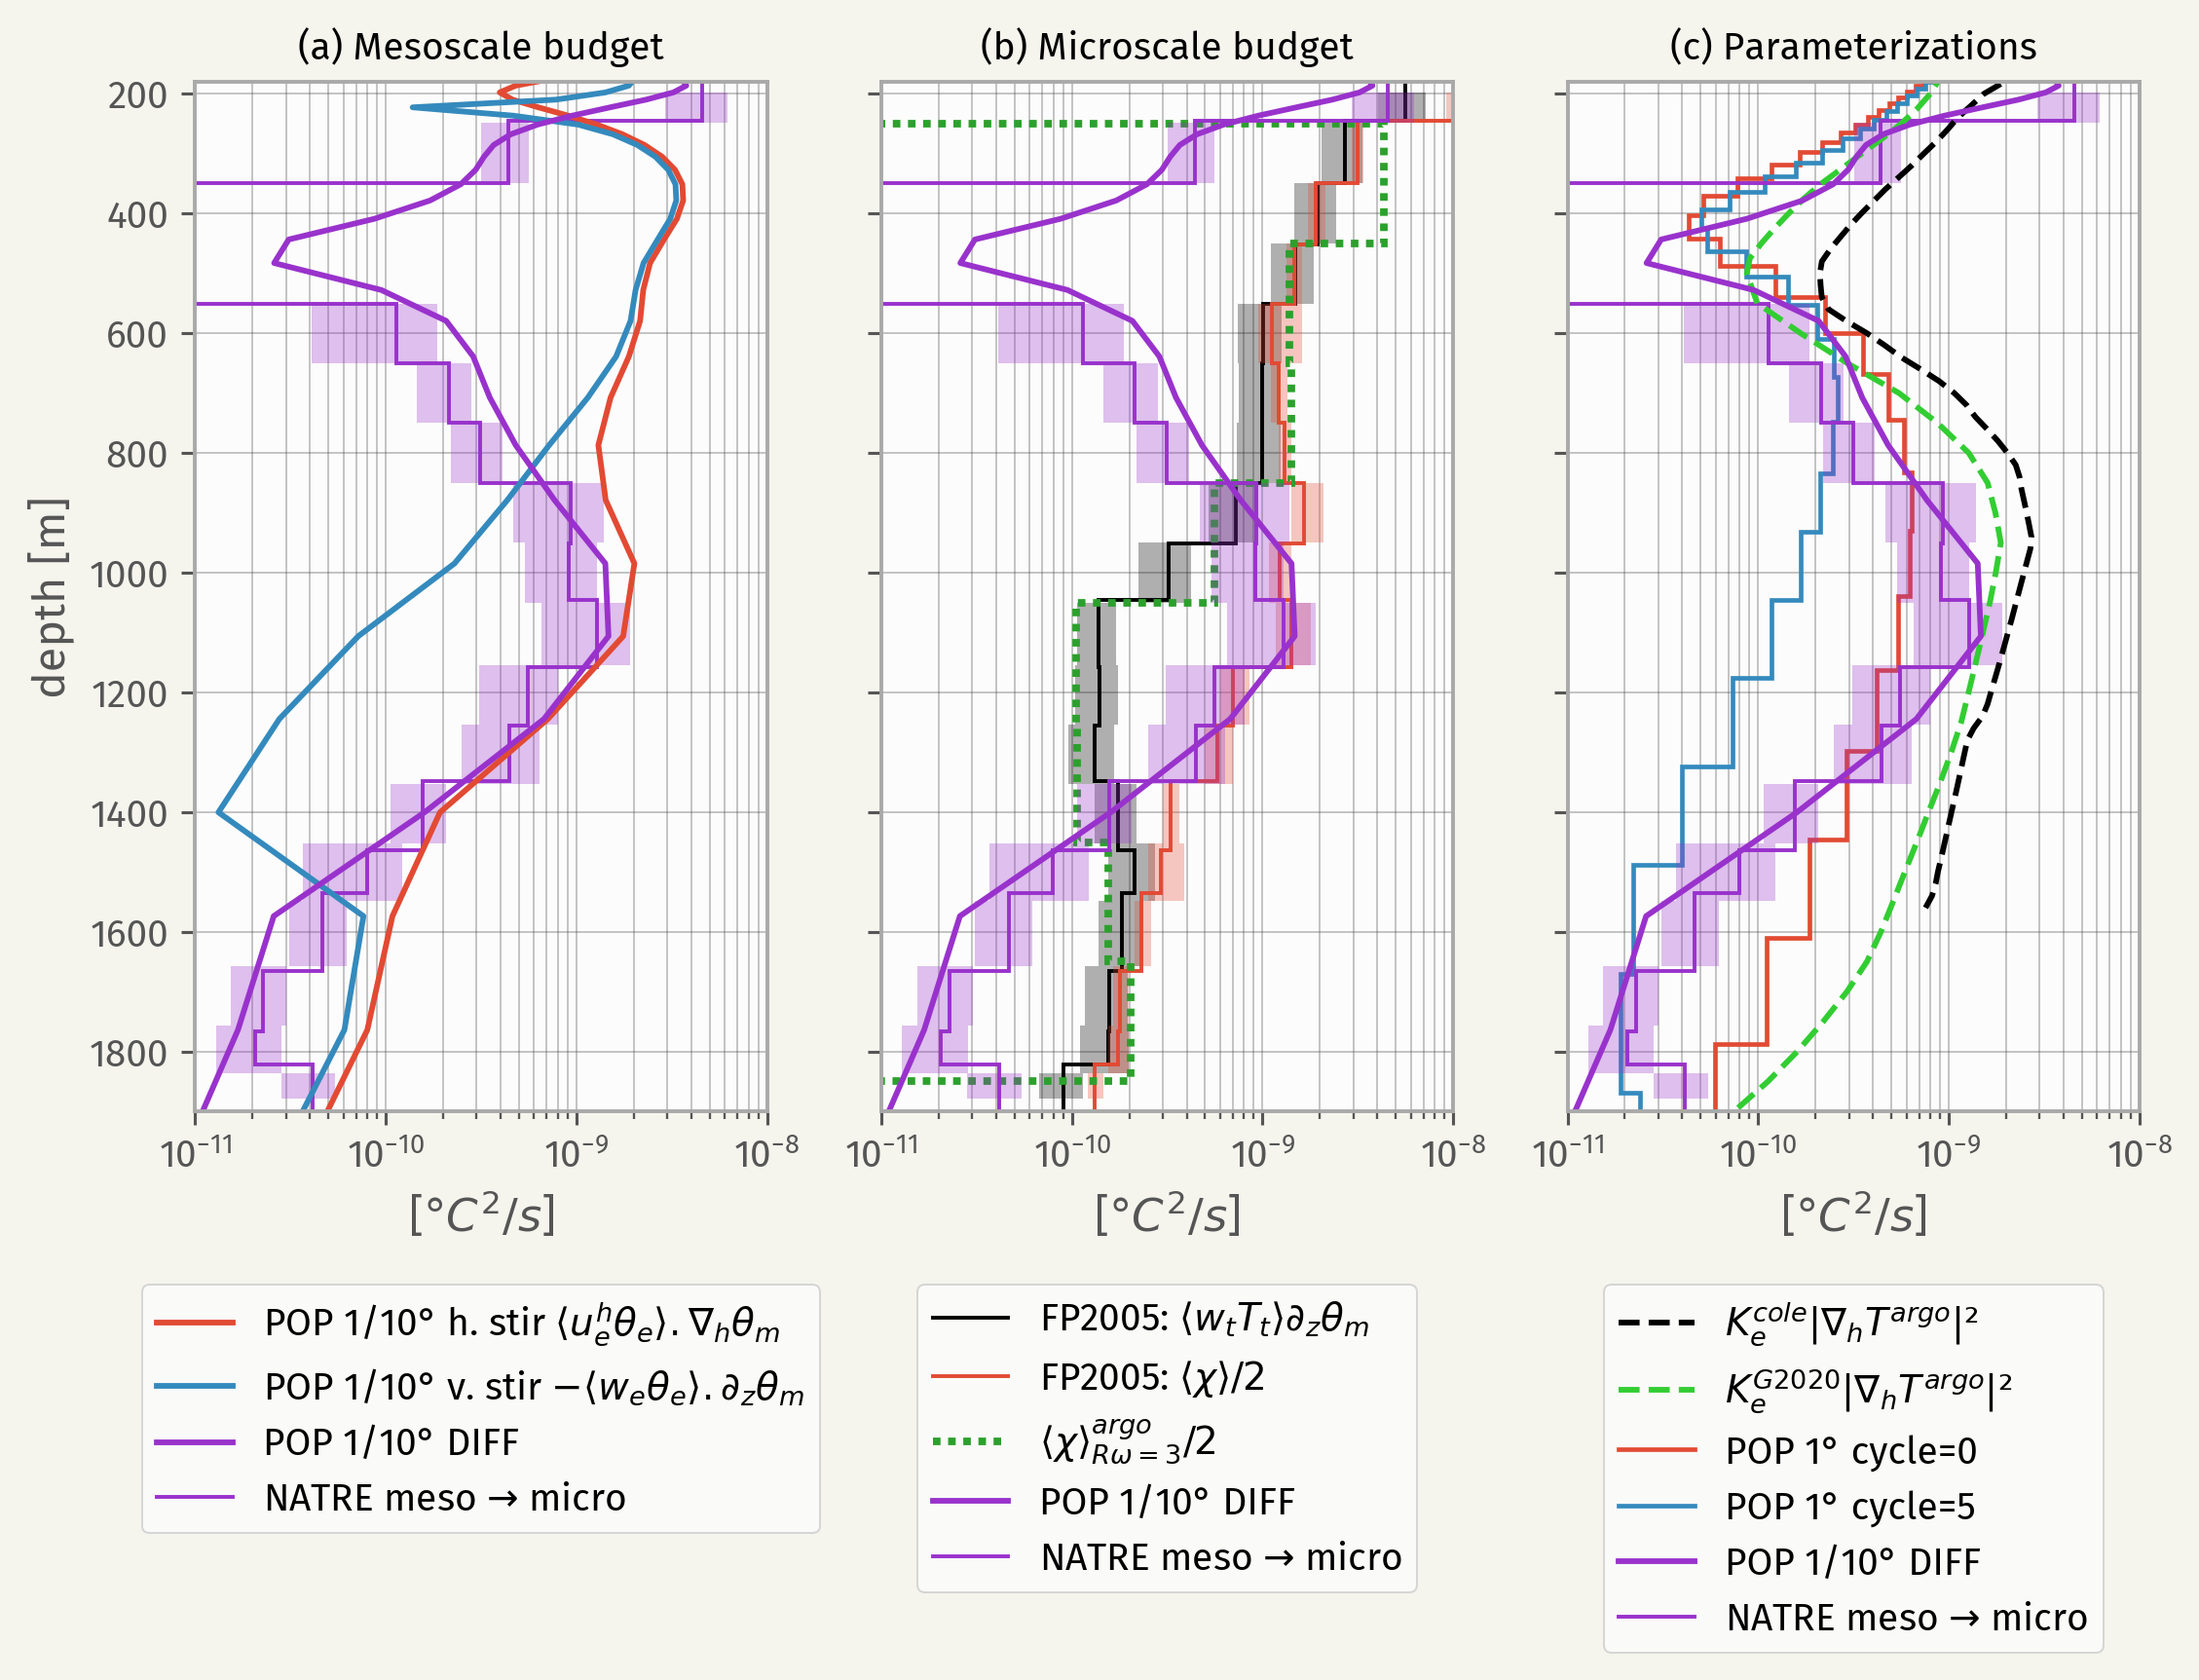

In [113]:
micro.pres.attrs["bounds"] = "pres_err"


def plot_pop_natre_meso_micro(ax):
    mesomicrocolor = "darkorchid"
    (-1 * pop_natre.DISS).cf.plot(
        ax=ax, lw=1.5, color=mesomicrocolor, label="POP 1/10° DIFF"
    )

    dcpy.plots.fill_between_bounds(
        micro,
        "residual",
        y="pres",
        color=mesomicrocolor,
        label="NATRE meso $→$ micro",
        ax=ax,
    )


f, ax = plt.subplots(1, 3, sharey=True, sharex=True, constrained_layout=False)

### Mesoscale budget
pop_natre.BC.cf.plot(ax=ax[0], label="POP 1/10° h. stir $⟨u_e^h θ_e⟩.∇_hθ_m$")
(np.abs(pop_natre.PKC)).cf.plot(ax=ax[0], label="POP 1/10° v. stir $-⟨w_eθ_e⟩.∂_zθ_m$")
# (-1 * pop_natre.VMIX).cf.plot(color="sienna", ax=ax[0], label="POP VMIX")
# (-1 * pop_natre.HDIFF).cf.plot(ax=ax[0], label="POP HDIFF", marker="x", ls="none")


### Microscale budget
plt.sca(ax[1])

dcpy.plots.fill_between_bounds(
    micro,
    "KρTz2",
    y="pres",
    color="k",
    label="FP2005: $⟨w_t T_t⟩ ∂_zθ_m$",
    # stairs_kwargs=dict(lw=1.5),
)
dcpy.plots.fill_between_bounds(
    micro,
    "chib2",
    y="pres",
    color="C0",
    label="FP2005: $⟨χ⟩/2$",
    # stairs_kwargs=dict(lw=1.5),
)

dcpy.plots.fill_between_bounds(
    (argo_fine_depth.sel(criteria="whalen") / 2),
    "χ",
    stairs_kwargs=dict(lw=2, ls=(0, (1, 1))),
    color="tab:green",
    fill=False,
    ax=plt.gca(),
    y="pressure",
    label="$⟨χ⟩^{argo}_{Rω=3}/2$",
)


### Parameterizations
cole_var.plot(
    y="pres", label="$K_e^{cole} |∇_hT^{argo}|²$", color="k", ls="--", ax=ax[2]
)
# groeskamp.eddy_var_0.plot(
#    y="pres",
#    label="$K_e^{G2020unsupp} |∇_hT^{cole}|²$",
#    color="limegreen",
#    ls="-.",
#    ax=ax[2],
# )
groeskamp.eddy_var.plot(
    y="pres", label="$K_e^{G2020} |∇_hT^{argo}|²$", color="limegreen", ls="--", ax=ax[2]
)

for cycle in [0, 5]:
    pop = pop_1deg_natre.isel(cycle=cycle)
    pop = pop.where(pop.z_t.notnull(), drop=True)
    pop = pop.cf.add_bounds("z_t")
    ybounds = pop.z_t_bounds
    bdim = pop.cf.get_bounds_dim_name("z_t")
    yedges = np.append(ybounds.isel({bdim: 0}).data, ybounds[-1, -1])
    ax[2].stairs(
        pop.RediVar,
        edges=yedges,
        orientation="horizontal",
        lw=1.2,
        label=f"POP 1° cycle={cycle}",
    )

### Cleanup
for idx, axx in enumerate(ax):
    plot_pop_natre_meso_micro(axx)
    axx.set_xscale("log")
    axx.set_xlabel("")
    axx.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15))
    axx.grid(True, which="both", lw=0.5)
    axx.set_xlabel("[$°C^2/s$]")
# ax[1].set_xlabel("Variance production or dissipation [°C²/s]")

# f.suptitle("NATRE")
ax[0].set_title("(a) Mesoscale budget", fontsize="medium")
ax[1].set_title("(b) Microscale budget", fontsize="medium")
ax[2].set_title("(c) Parameterizations", fontsize="medium")

ax[0].set_xlim([1e-11, 1e-8])
ax[0].set_ylim([1900, 180])

dcpy.plots.clean_axes(ax)
f.set_size_inches((9.2, 5))

# f.savefig("../images/natre-meso-micro-param.png")

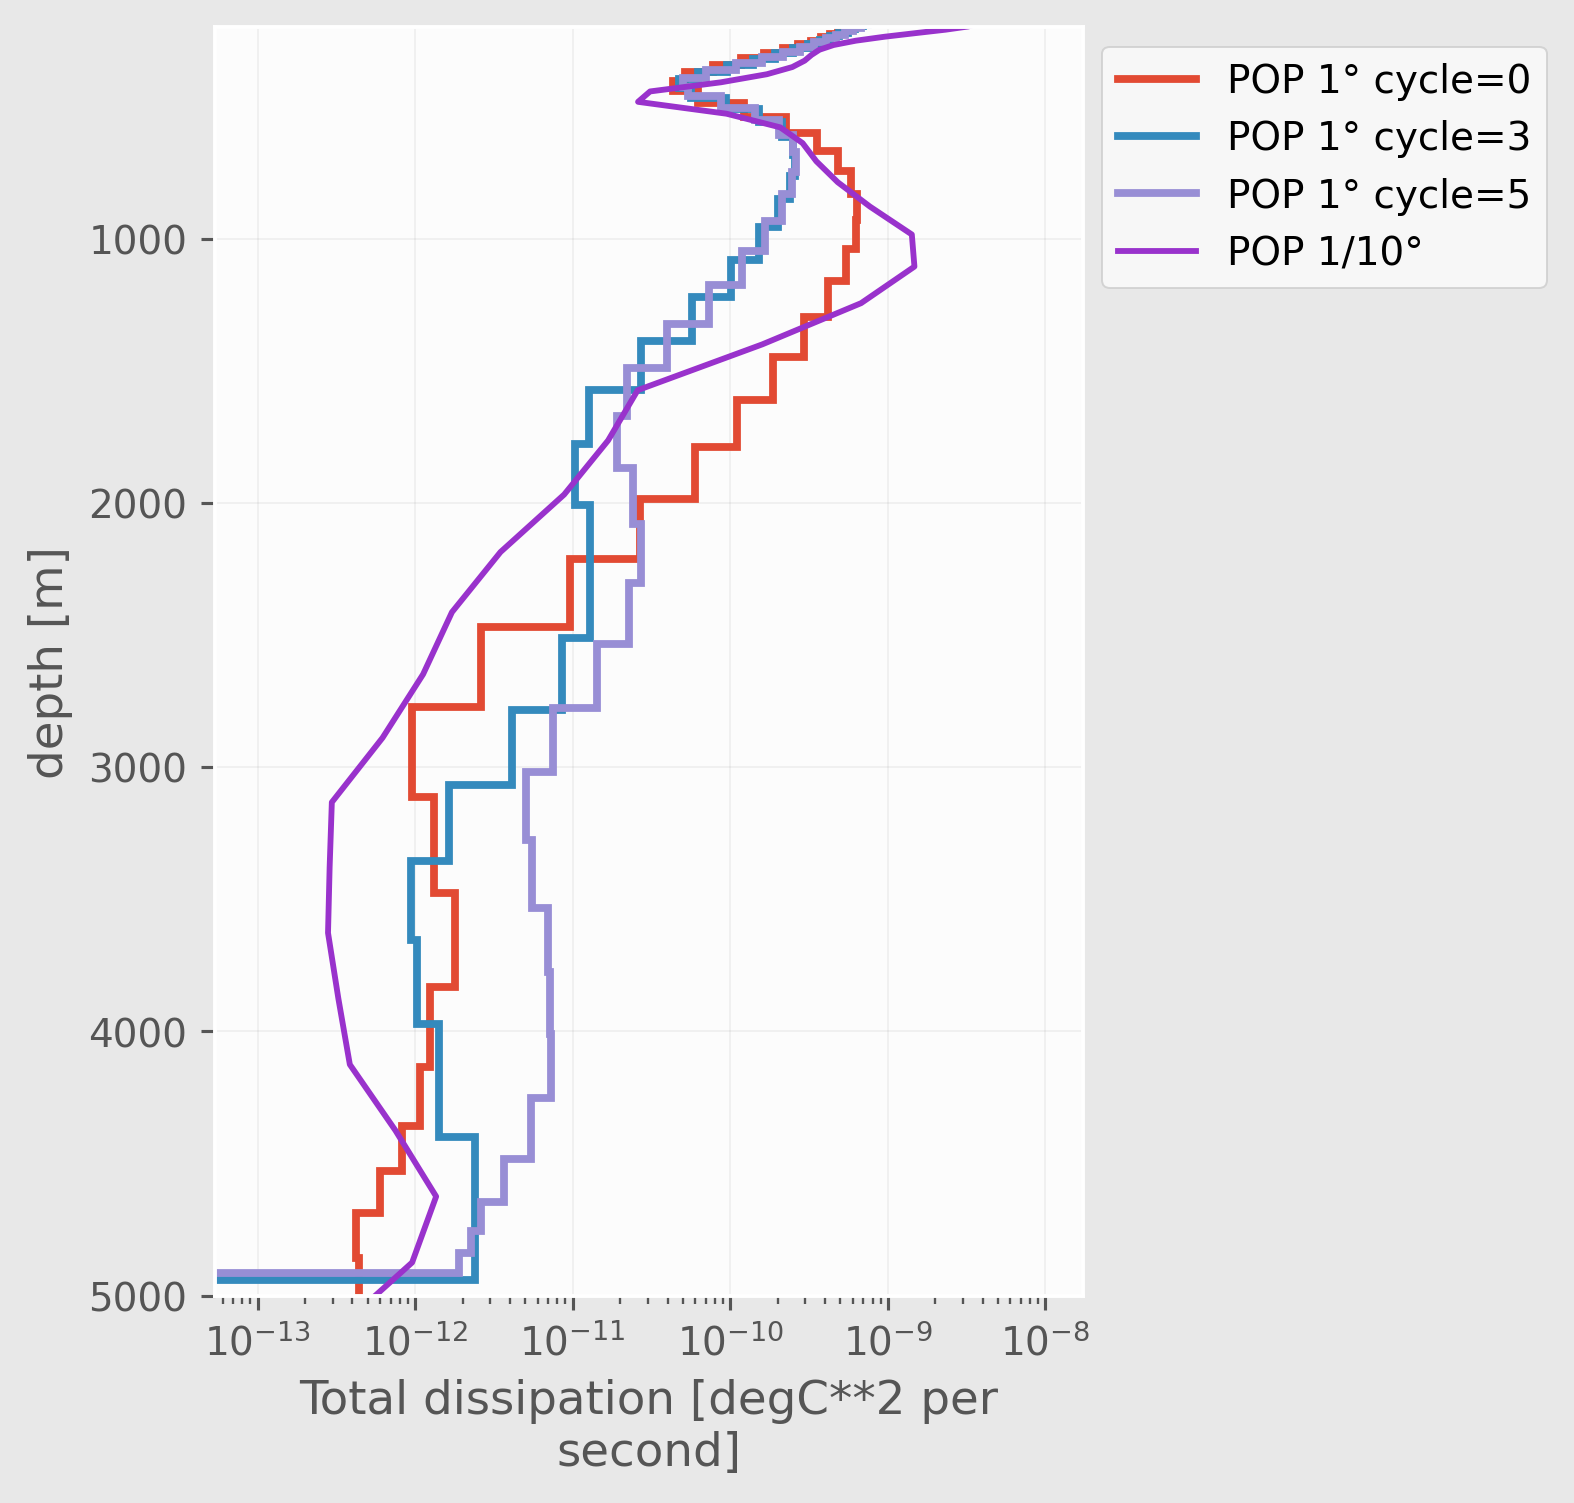

In [58]:
f, ax = plt.subplots(1, 1)

for cycle in [0, 3, 5]:
    pop = pop_1deg_natre.isel(cycle=cycle)
    pop = pop.where(pop.z_t.notnull(), drop=True)
    pop = pop.cf.add_bounds("z_t")
    ybounds = pop.z_t_bounds
    bdim = pop.cf.get_bounds_dim_name("z_t")
    yedges = np.append(ybounds.isel({bdim: 0}).data, ybounds[-1, -1])
    ax.stairs(
        pop.RediVar,
        edges=yedges,
        orientation="horizontal",
        lw=2,
        label=f"POP 1° cycle={cycle}",
    )
ax.set_ylim((5000, 200))

mesomicrocolor = "darkorchid"
(-1 * pop_natre.DISS).cf.plot(ax=ax, lw=1.5, color=mesomicrocolor, label="POP 1/10°")
ax.set_xscale("log")
ax.legend(bbox_to_anchor=(1, 1))
f.set_size_inches((4, 6))

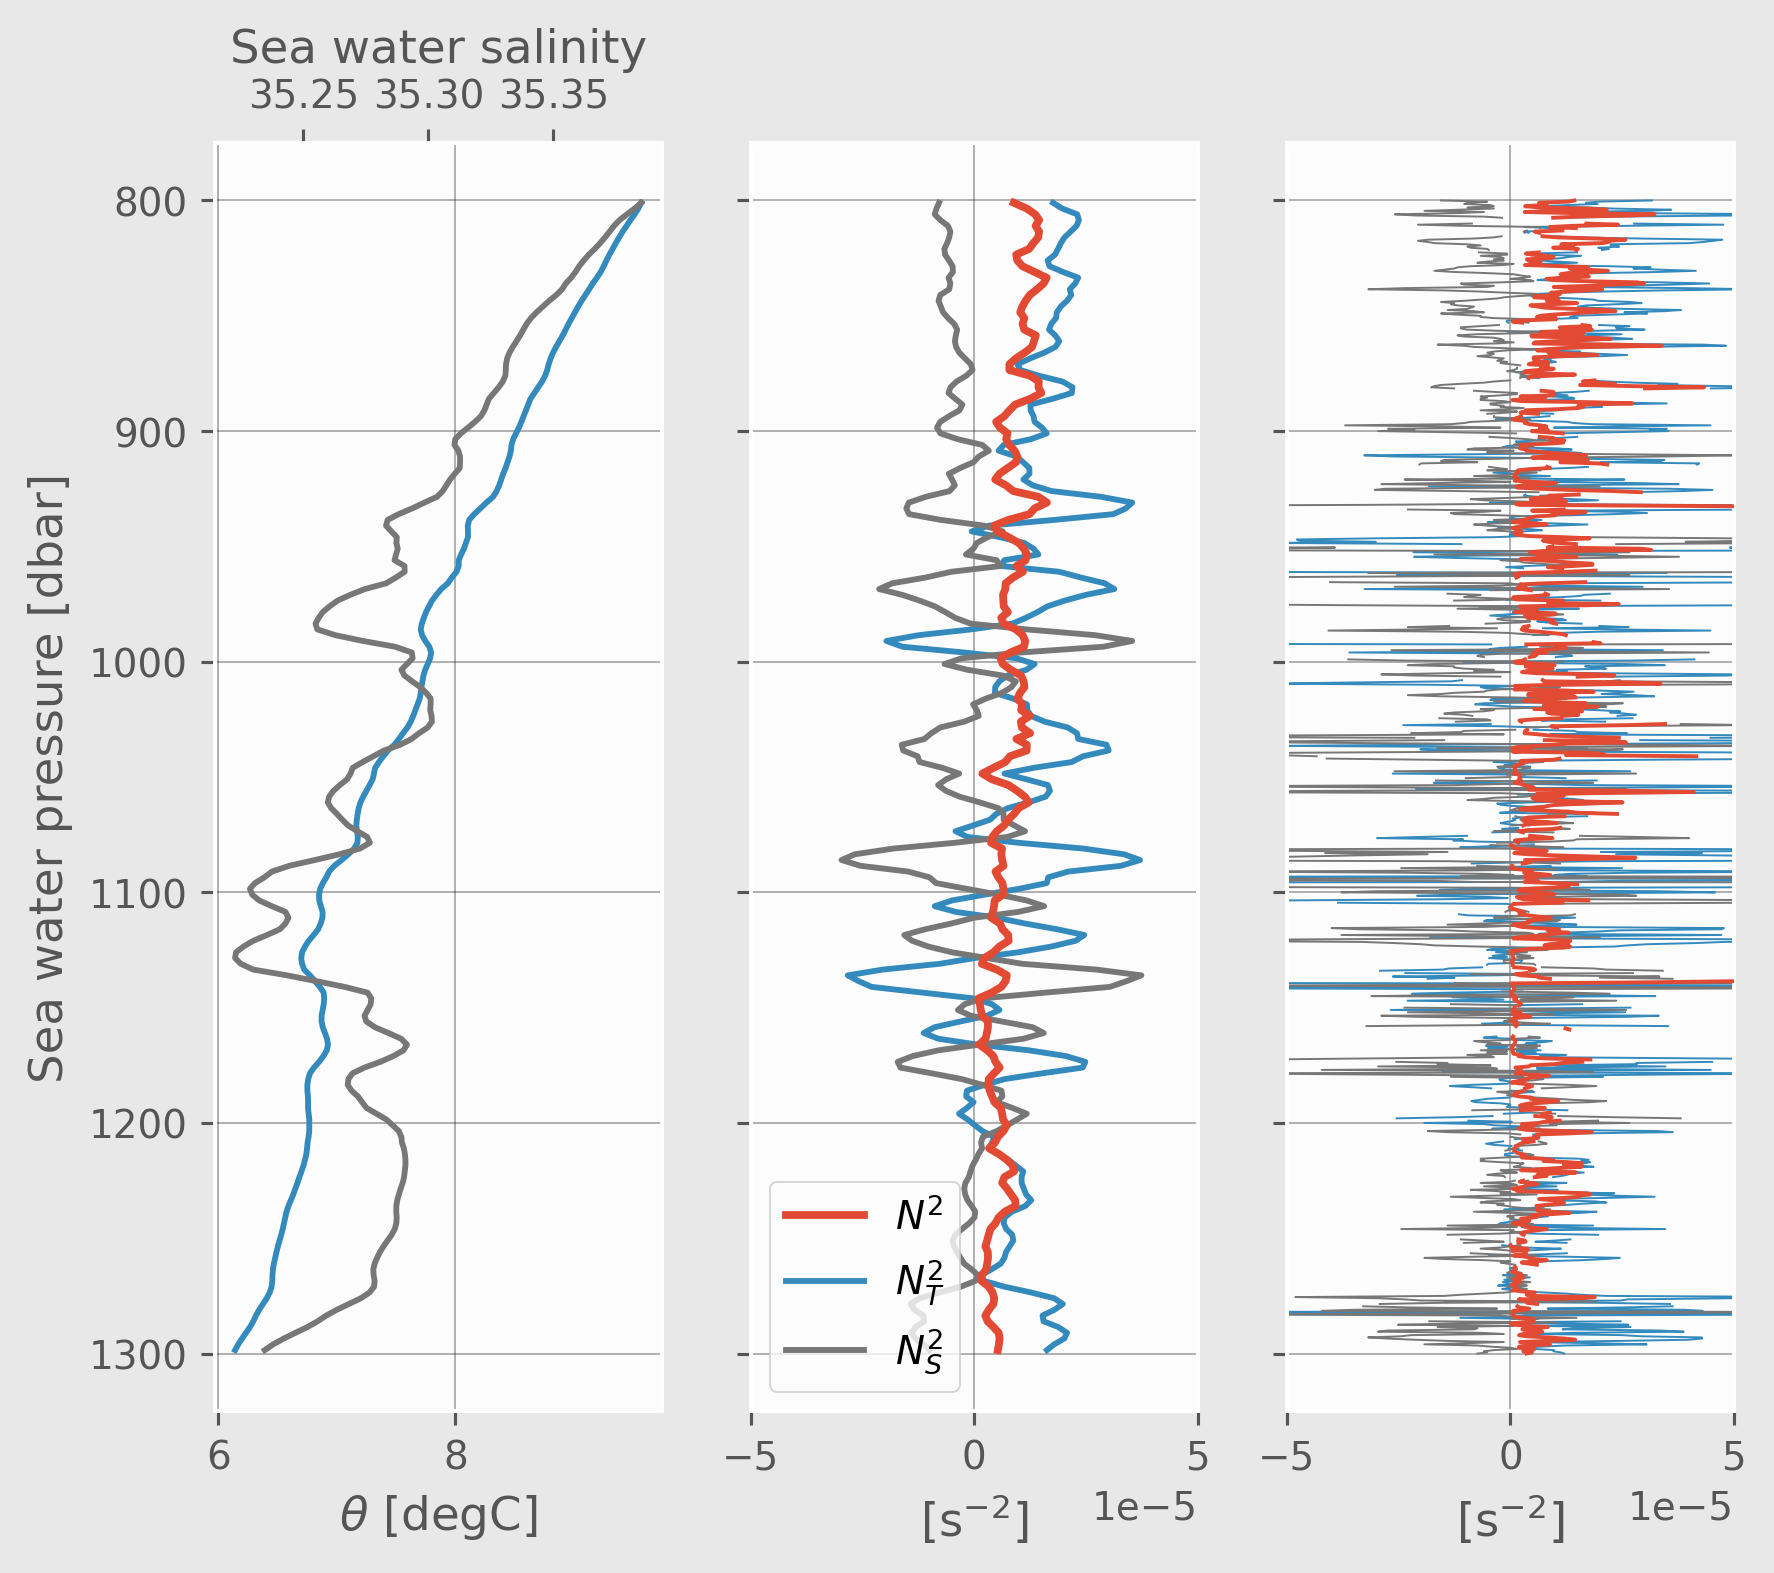

In [88]:
profile = natre.isel(latitude=3, longitude=6)

profile["NT2"] = (
    -9.81
    * dcpy.eos.alpha(profile.salt, profile.temp, profile.pres)
    * profile.theta.interpolate_na("pres").differentiate("pres")
)
profile["NS2"] = (
    9.81
    * dcpy.eos.beta(profile.salt, profile.temp, profile.pres)
    * profile.salt.interpolate_na("pres").differentiate("pres")
)

smoothed = (
    profile.rolling(pres=21, center=True, min_periods=1)
    .mean()
    .coarsen(pres=5, boundary="trim")
    .mean()
    .sel(pres=slice(800, 1300))
)

smoothed["NT2"] = (
    -9.81
    * dcpy.eos.alpha(smoothed.salt, smoothed.temp, smoothed.pres)
    * smoothed.theta.interpolate_na("pres").differentiate("pres")
)
smoothed["NS2"] = (
    9.81
    * dcpy.eos.beta(smoothed.salt, smoothed.temp, smoothed.pres)
    * smoothed.salt.interpolate_na("pres").differentiate("pres")
)

f, ax = plt.subplots(1, 3, sharey=True)

smoothed.theta.cf.plot(ax=ax[0], color="C1")

axS = ax[0].twiny()
axS.grid(False)
smoothed.salt.cf.plot(color="C3", ax=axS)

# ax2 = ax[0].twiny()
# smoothed.gamma_n.cf.plot(color="k", ax=ax2)
# ax2.grid(False)

smoothed.N2.cf.plot(lw=2, zorder=5, ax=ax[1])
smoothed.NT2.cf.plot(ax=ax[1])
smoothed.NS2.cf.plot(color="C3", ax=ax[1])
ax[1].set_xlim([-5e-5, 5e-5])
ax[1].legend(["$N^2$", "$N_T^2$", "$N_S^2$"])

profile.N2.sel(pres=slice(800, 1300)).cf.plot(lw=1, zorder=5, ax=ax[2])
profile.NT2.sel(pres=slice(800, 1300)).cf.plot(ax=ax[2], lw=0.5)
profile.NS2.sel(pres=slice(800, 1300)).cf.plot(color="C3", ax=ax[2], lw=0.5)
ax[2].set_xlim([-5e-5, 5e-5])
# ax[2].legend(["$N^2$", "$N_T^2$", "$N_S^2$"])

dcpy.plots.clean_axes(ax)
[aa.set_title("") for aa in ax]
axS.set_title("")
ax[1].set_xlabel("[s$^{-2}$]")

f.set_size_inches((7, 6))

### Nice matplotlib map

In [15]:
import cartopy.crs as ccrs

natre = ed.natre.read_natre()
lats, lons = np.meshgrid(natre.latitude, natre.longitude)

a05 = xr.load_dataset("../datasets/a05-section.nc").query({"cast": "longitude > -35"})
with_chi = a05[["latitude", "longitude"]].where(
    a05.chi.count("pressure") > 0, drop=True
)


plt.rcParams["axes.facecolor"] = "none"

f, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))

topo.plot(
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    vmin=-5000,
    vmax=5000,
    cmap="RdBu_r",
    center=0,
)

topo.plot.contour(transform=ccrs.PlateCarree(), levels=[0], colors="k")


(h1,) = ax.plot(
    lons.ravel(),
    lats.ravel(),
    color="w",
    marker="o",
    ls="none",
    ms=2,
    transform=ccrs.PlateCarree(),
)

(h0,) = ax.plot(
    a05.longitude, a05.latitude, marker=".", lw=0.5, transform=ccrs.PlateCarree()
)
(h1,) = ax.plot(
    with_chi.longitude,
    with_chi.latitude,
    color="k",
    ls="none",
    ms=4,
    marker=".",
    transform=ccrs.PlateCarree(),
)

for cast in with_chi.cast.data:
    subset = with_chi.sel(cast=cast)
    ax.text(
        subset.longitude,
        subset.latitude - 0.75,
        str(cast),
        rotation=45,
        fontsize=5,
        color="w",
        va="top",
        ha="right",
    )
f.savefig("../images/A05-NATRE-domain.png")

# ax.legend([h0, h1], ["GO-SHIP A05", "NATRE"])

KeyError: "Dataset.cf does not understand the key 'sea_water_salinity'. Use 'repr(Dataset.cf)' (or 'Dataset.cf' in a Jupyter environment) to see a list of key names that can be interpreted."

Font 'default' does not have a glyph for '\u2207' [U+2207], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2207' [U+2207], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2207' [U+2207], substituting with a dummy symbol.


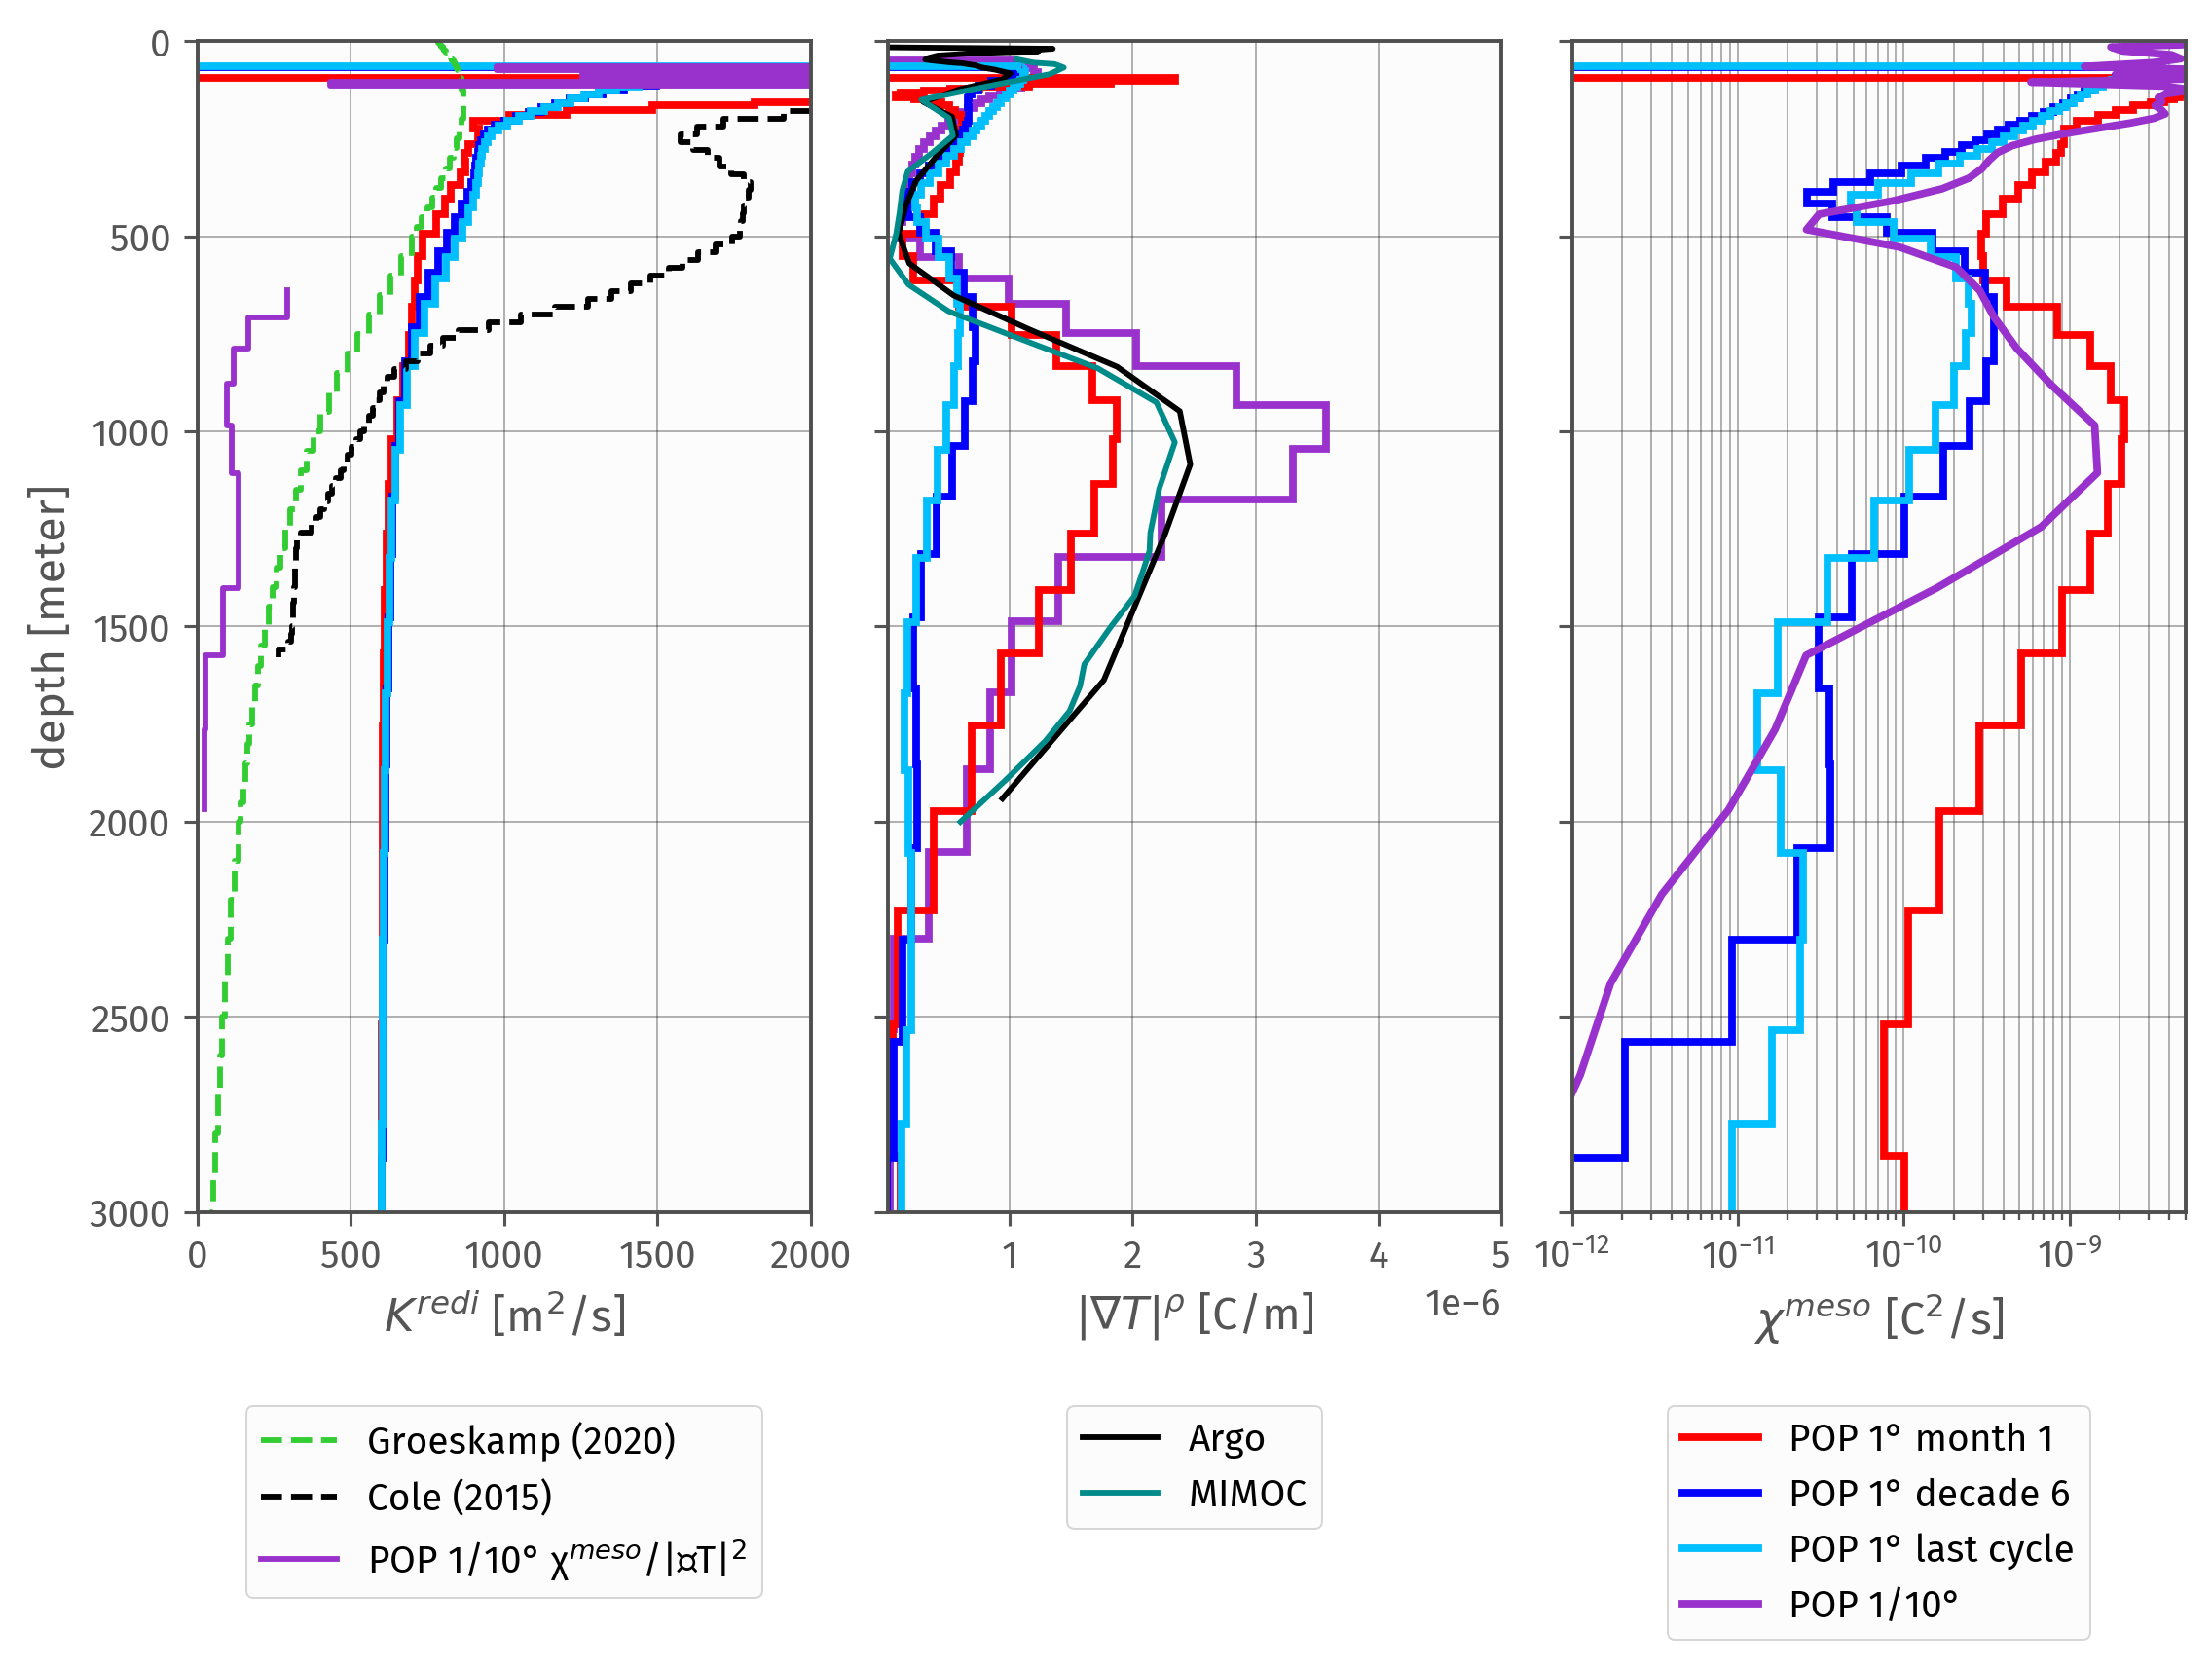

In [190]:
plt.rcParams["figure.dpi"] = 140
plt.rcParams["figure.facecolor"] = "none"  # (0.91, 0.91, 0.91)
plt.rcParams["axes.facecolor"] = (0.99,) * 3
plt.rcParams.update(
    {
        "axes.spines.top": True,
        "axes.spines.bottom": True,
        "axes.spines.left": True,
        "axes.spines.right": True,
        "axes.edgecolor": (0.31,) * 3,
        "axes.grid.which": "both",
        "grid.linewidth": 0.5,
        "grid.alpha": 0.3,
        "grid.color": (0,) * 3,
    }
)

hirescolor = "darkorchid"
spinupcolor = "r"
spinupendcolor = "b"
lastcyclecolor = "deepskyblue"

f, axx = plt.subplots(1, 3, sharey=True, constrained_layout=True)
ax = dict(zip(["K", "delT2", "chi"], axx))

for pop_, color, label in zip(
    [
        pop_hires_clim_profile,
        year1_profile.squeeze(),
        pop_1deg_spinup_profile.isel(decade=5),
        pop_1deg_natre_profile.sel(cycle=5),
    ],
    [hirescolor, spinupcolor, spinupendcolor, lastcyclecolor],
    ["POP 1/10°", "POP 1° month 1", "POP 1° decade 6", "POP 1° last cycle"],
):
    kwargs = dict(edges=get_edges(pop_), orientation="horizontal", lw=2, color=color)
    ax["delT2"].stairs(np.sqrt(pop_.delT2_plane.data), **kwargs)
    if "KAPPA_ISOP" in pop_:
        ax["K"].stairs(pop_.KAPPA_ISOP.to_numpy(), **kwargs)
        ax["chi"].stairs(pop_.RediVar.to_numpy(), **kwargs, label=label)

# K
groeskamp.Ke.cf.plot.step(
    y="pres", ax=ax["K"], color="limegreen", ls="--", label="Groeskamp (2020)"
)
cole_natre.diffusivity.cf.plot.step(
    y="pres", ax=ax["K"], color="k", ls="--", label="Cole (2015)"
)
pop_hires_clim_profile.Ke.drop_vars("z_σ").cf.plot.step(
    y="depth",
    ax=ax["K"],
    xlim=[0, 3000],
    color=hirescolor,
    label="POP 1/10° χ$^{meso}$/|∇T|$^2$",
)

# ∇T2
for data, color, label in zip(
    [argo_delT2_plane, mimoc_natre_profile.delT2_plane.rename({"pressure": "pres"})],
    ["k", "darkcyan"],
    ["Argo", "MIMOC"],
):
    np.sqrt(data).cf.plot(
        y="pres", ax=ax["delT2"], color=color, label=label, _labels=False
    )

# χmeso
(-1 * pop_natre.DISS).cf.plot(
    ax=ax["chi"], lw=2, color=hirescolor, label="POP 1/10°", _labels=False
)

ax["K"].set_xlabel("$K^{redi}$ [m$^2$/s]")
ax["chi"].set_xlabel("$χ^{meso}$ [C$^2$/s]")
ax["delT2"].set_xlabel("$|∇T|^ρ$ [C/m]")

ax["chi"].set_xscale("log")
# ax["delT2"].set_xscale("log")

axx[0].set_title("")
axx[0].set_ylim([3000, 0])
axx[0].set_xlim([0, 2000])
axx[1].set_xlim([1e-8, 5e-6])
axx[-1].set_xlim([1e-12, 5e-9])
dcpy.plots.clean_axes(axx)
for a in axx:
    a.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15))
f.set_size_inches((8, 6))